In [ ]:
# TODO
# group low count car makes into other and other_luxury (using special imputer?)
# handle skewed price variable
# look at residuals
# look at feature importances using per feature prediction and from the tree models (does gradient boosted trees have feature importances?)
# get grid search working for rand forest. For some reason not completing even on 2 param settings
# layout notebook as learning resource with all regression models first and then a selection of models to do grid search on

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

set_config(transform_output="pandas")

# download data from s3 to a sagemaker notebook

In [ ]:
bucket='205-datasets'
data_key = 'used-cars/train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
raw = pd.read_csv(data_location)

# local data load

In [29]:
raw = pd.read_csv("data/used-cars.csv")
raw.drop("Unnamed: 0", axis=1, inplace=True)
raw.columns = [x.lower() for x in raw.columns]

# EDA / cleanup

In [62]:
# Leave raw untouched to revert back to original dataset incase you mess things up
cars = raw.copy()

In [31]:
cars.head()

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,new_price,price
0,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
1,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,13 km/kg,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
2,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
3,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74
4,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,NaN,3.50


In [33]:
cars.dtypes

name                  object
location              object
year                   int64
kilometers_driven      int64
fuel_type             object
transmission          object
owner_type            object
mileage               object
engine                object
power                 object
seats                float64
new_price             object
price                float64
dtype: object

In [7]:
# convert columns with units to numerical columns by removing units
def remove_units(df):
    return df.apply(lambda x: x.str.split(" ").str[0].astype("float"))

In [8]:
cars[["mileage", "engine", "power"]] = remove_units(cars[["mileage", "engine", "power"]])

In [9]:
cars.describe().round(decimals=2)

,year,kilometers_driven,mileage,engine,power,seats,price
count,5847.00,5847.00,5845.00,5811.00,5811.00,5809.00,5847.00
mean,2013.45,58410.13,18.16,1631.55,113.80,5.29,9.65
std,3.19,92379.71,4.36,601.97,53.90,0.81,11.28
min,1998.00,171.00,0.00,72.00,34.20,2.00,0.44
25%,2012.00,33467.50,15.26,1198.00,78.00,5.00,3.55
50%,2014.00,52576.00,18.19,1497.00,98.60,5.00,5.75
75%,2016.00,72490.50,21.10,1991.00,139.01,5.00,10.25
max,2019.00,6500000.00,28.40,5998.00,560.00,10.00,160.00


Some data observations:
 - Missing values in mileage, engine, power, and seats
 - Some cars with a milage of 0.00 which seem to be electric cars

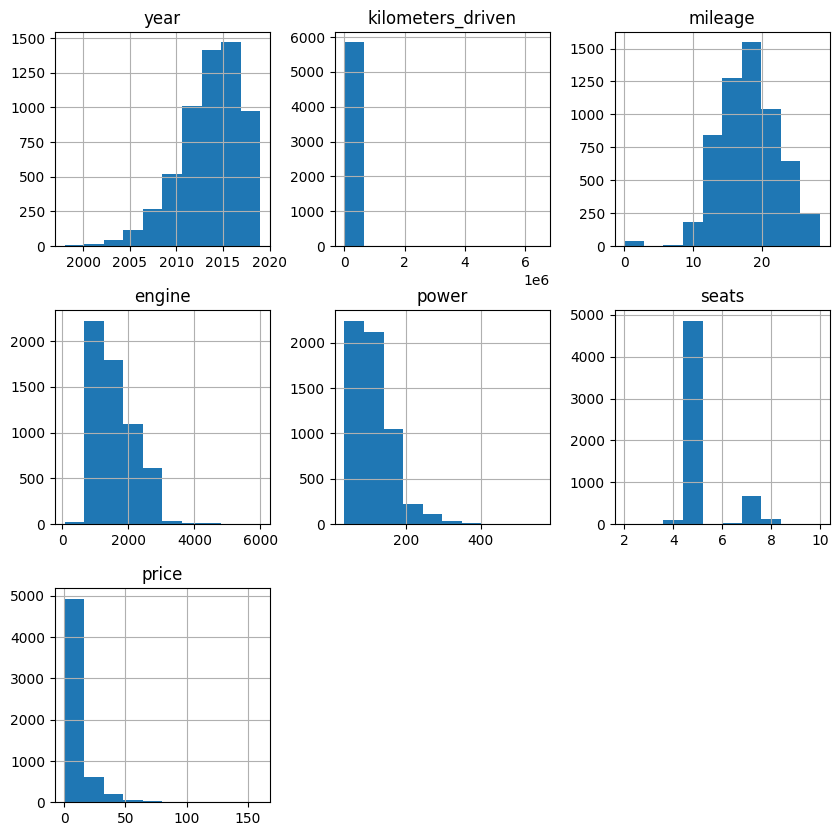

In [10]:
cars.hist(figsize=(10, 10))
plt.show()

High skew in the target variable could create problems when training by overfitting to outlier values or having different
distributions in training vs validation sets. Remediate by straified CV, log scaling, and using absolute err versus squared err 
for training when possible

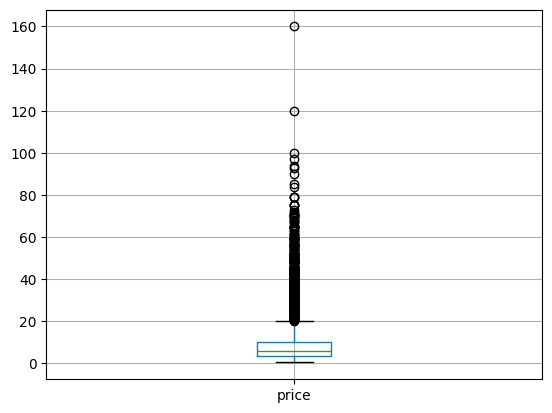

In [11]:
cars.boxplot(column="price")
plt.show()

In [12]:
# extract car make from the name variable as a category
def car_make(df):
    return df.apply(lambda x: x.str.split(" ").str[0].str.lower())

In [13]:
cars[["make"]] = car_make(cars[["name"]])

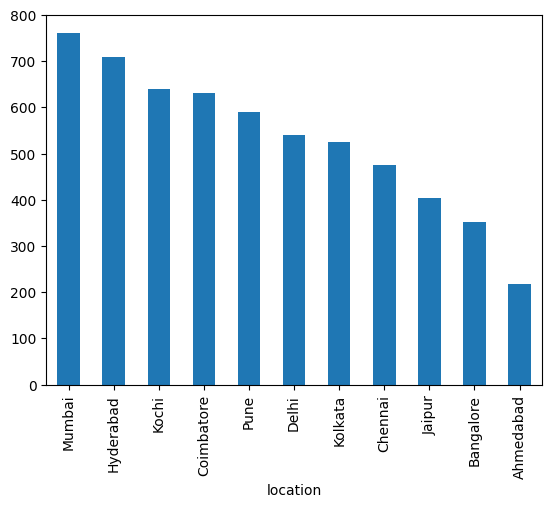

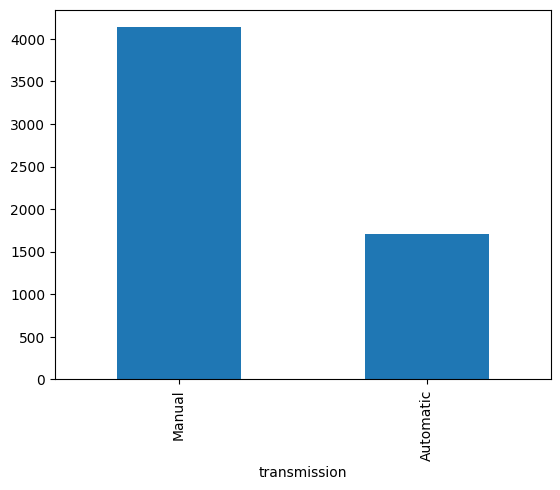

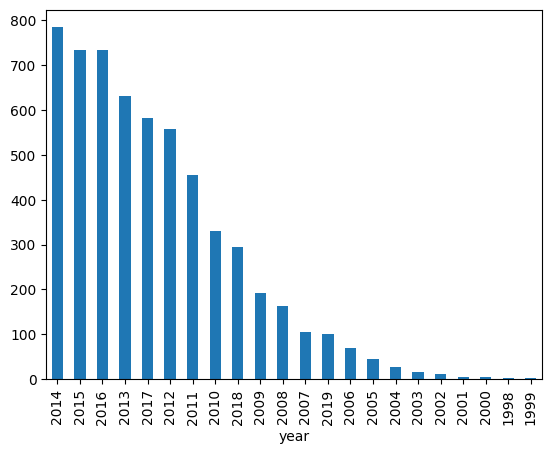

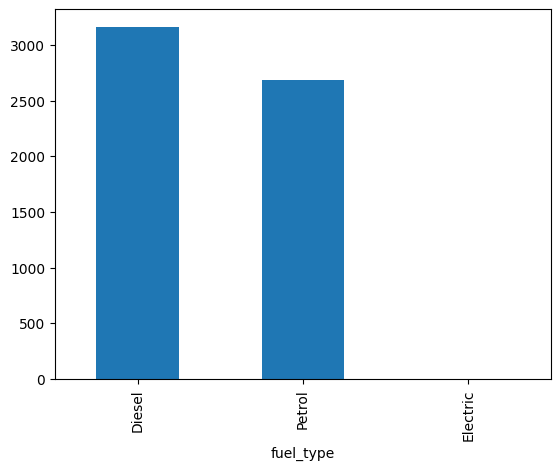

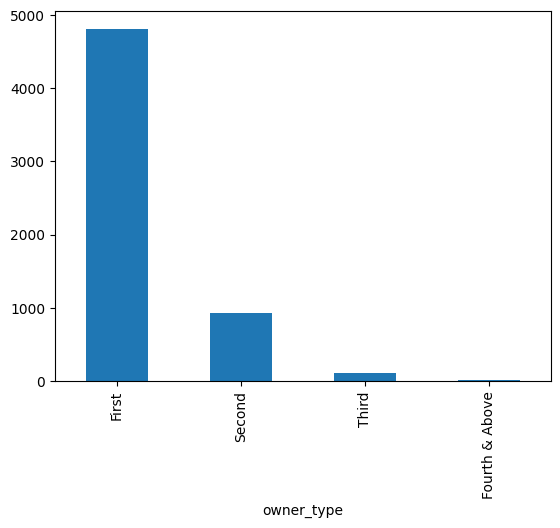

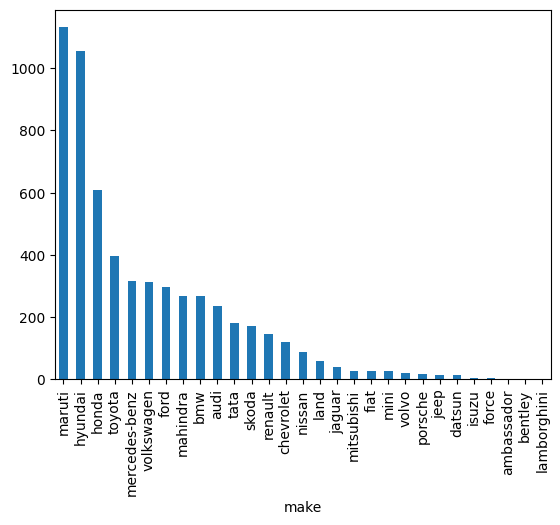

In [14]:
for col in ["location", "transmission", "year", "fuel_type", "owner_type", "make"]:
    cars[col].value_counts().plot(kind='bar')
    plt.show()

In [15]:
cars["owner_type"].value_counts()

owner_type
First             4811
Second             925
Third              103
Fourth & Above       8
Name: count, dtype: int64

In [16]:
# some of these less common makes should be binned together. Potentially into an "other" and "other_luxury" category
cars["make"].value_counts()

make
maruti           1132
hyundai          1057
honda             607
toyota            395
mercedes-benz     316
volkswagen        314
ford              295
mahindra          269
bmw               267
audi              235
tata              181
skoda             172
renault           145
chevrolet         120
nissan             89
land               60
jaguar             40
mitsubishi         27
fiat               26
mini               26
volvo              21
porsche            16
jeep               15
datsun             13
isuzu               3
force               3
ambassador          1
bentley             1
lamborghini         1
Name: count, dtype: int64

In [17]:
# in reality would want a data set with more electric cars since these are going to be categorically very different
# and couldnt be binned into a different category
cars["fuel_type"].value_counts()

fuel_type
Diesel      3161
Petrol      2684
Electric       2
Name: count, dtype: int64

# create pipeline with custom transformers
These custom transformers take in a dataframe of one or more columns and apply the transformations to all columns and return the transformed data frame

In [24]:
# NOTE: redefine transformers from EDA here 

# convert columns with units to numerical columns by removing units
def remove_units(df):
    return df.apply(lambda x: x.str.split(" ").str[0].astype("float"))

# extract car make from the name variable as a category
def car_make(df):
    return df.apply(lambda x: x.str.split(" ").str[0].str.lower())

# years old versus year manufactured is a slightly more interpretable variable and puts out data on a more normal scale
def convert_years(df):
    return df.apply(lambda x: 2019 - x)

# because the fourth and above category is very small in the dataset, just group with the third owner category
def bin_owner(df):
    return df.map(lambda x: "Third" if x not in ["First", "Second"] else x)

# map the number of owners to an ordinal variable
def ordinal_owner(df):
    owner_map = {
        "First": 1,
        "Second": 2,
        "Third": 3
    }
    
    return df.map(lambda x: owner_map[x])

In [25]:
# create pipeline by defining indivual pipelines for columns that need to be acted on by more than one transformer

owner_pipeline = Pipeline(
    [
        ('bin_third_plus', FunctionTransformer(bin_owner)),
        ('ordinal_encode', FunctionTransformer(ordinal_owner))
    ]
)

car_make_pipeline = Pipeline(
    [
        ('parse_car_make', FunctionTransformer(car_make)),
        ('car_make_ohe', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)

cols_with_units_pipeline = Pipeline(
    [
        ("remove_units", FunctionTransformer(remove_units)),
        ("standard_scaler", StandardScaler())
    ]
)

# define column transformer to apply transformations to specific columns

ct_transformer = ColumnTransformer(
    [
         # seems to only work when passed a list of column names and expects function to take and return a dataframe
        ("owner", owner_pipeline, ["owner_type"]),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["location", "fuel_type"]),
        ("numeric_with_units", cols_with_units_pipeline, ["mileage", "engine", "power"]),
        ("orde", OrdinalEncoder(), ["transmission"]),
        ("years_old", FunctionTransformer(convert_years), ["year"]),
        ("car_make", car_make_pipeline, ["name"]),
    ]
)

# add imputer on all columns to handle missing values

preprocessing_pipeline = Pipeline(
    [
        ("column_transformers", ct_transformer),
        ("imputer", SimpleImputer(strategy='mean'))
    ]
)

In [26]:
# view the pipeline diagram
preprocessing_pipeline

Pipeline(steps=[('column_transformers',
                 ColumnTransformer(transformers=[('owner',
                                                  Pipeline(steps=[('bin_third_plus',
                                                                   FunctionTransformer(func=<function bin_owner at 0x2b9ec71f0>)),
                                                                  ('ordinal_encode',
                                                                   FunctionTransformer(func=<function ordinal_owner at 0x2b9ec7310>))]),
                                                  ['owner_type']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['location...
                                                 ('orde', OrdinalEncoder(),
                                                  ['transmission']),
                                                 ('years_old',
                                                  FunctionTransformer(func=<function convert_years at 0x2b9ec74c0>),
                                                  ['year']),
                                                 ('car_make',
                                                  Pipeline(steps=[('parse_car_make',
                                                                   FunctionTransformer(func=<function car_make at 0x2b9ec7280>)),
                                                                  ('car_make_ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['name'])])),
                ('imputer', SimpleImputer())])

# view preprocessed data to validate preprocessing pipeline
!!! Remember to reinstantiate cars dataframe from beginning of  notebook so we get a clean dataset

In [34]:
preprocessed_data = preprocessing_pipeline.fit_transform(cars)

In [35]:
# is there an expanded describe that should unique counts or other types of metrics?
preprocessed_data.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
owner__owner_type,5847.0,1.196,0.442,1.000,1.000,1.000,1.000,3.000
ohe__location_Ahmedabad,5847.0,0.037,0.189,0.000,0.000,0.000,0.000,1.000
ohe__location_Bangalore,5847.0,0.060,0.238,0.000,0.000,0.000,0.000,1.000
ohe__location_Chennai,5847.0,0.081,0.273,0.000,0.000,0.000,0.000,1.000
ohe__location_Coimbatore,5847.0,0.108,0.310,0.000,0.000,0.000,0.000,1.000
ohe__location_Delhi,5847.0,0.092,0.290,0.000,0.000,0.000,0.000,1.000
ohe__location_Hyderabad,5847.0,0.121,0.327,0.000,0.000,0.000,0.000,1.000
ohe__location_Jaipur,5847.0,0.069,0.253,0.000,0.000,0.000,0.000,1.000
ohe__location_Kochi,5847.0,0.109,0.312,0.000,0.000,0.000,0.000,1.000
ohe__location_Kolkata,5847.0,0.090,0.286,0.000,0.000,0.000,0.000,1.000


# define model pipeline and test candidate model types

In [63]:
def make_pipeline(model):
    """Helper function to add predictive model to end off preprocessing pipeline"""
    return Pipeline(
        [
            ("preprocessing", preprocessing_pipeline),
            ("model", model),
        ]
    )

In [64]:
# split training dataset on X, y (assuming kaggle has a test data set so no need for one here)
X_train = cars.drop(["new_price", "price"], axis = 1)
y_train = cars["price"]

In [65]:
# Function to perform cross-validation and return scores
def cross_validate_models(models, X, y, num_cv=5, scoring='neg_mean_absolute_error'):
    results = []
    
    for name, model in models.items():
        start_time = time.time()
        pipeline = make_pipeline(model)
        scores = cross_val_score(pipeline, X, y, cv=num_cv, scoring=scoring, n_jobs=-1)
        duration = time.time() - start_time
        results.append({
            'Model': name,
            'Mean Score': np.mean(scores),
            'Std Dev': np.std(scores),
            'Min Score': np.min(scores),
            'Max Score': np.max(scores),
            'Duration': duration
        })
        print(f'{name} completed in {duration:.2f} seconds.')
        
    return pd.DataFrame(results)

In [66]:
models = {
    #'ridge': Ridge(),
    #'elastic_net': ElasticNet(),
    #'kernel_ridge': KernelRidge(),
    'grad_boost': GradientBoostingRegressor(random_state=0),
    'rand_forest': RandomForestRegressor(random_state=0),
    'decision_tree': DecisionTreeRegressor(random_state=0),
    #'SVR': SVR(),
    #'kneighbors': KNeighborsRegressor()
}

In [67]:
# Call the function with your data
cv_results = cross_validate_models(models, X_train, y_train)

grad_boost completed in 0.80 seconds.
rand_forest completed in 1.14 seconds.
decision_tree completed in 0.45 seconds.


In [68]:
cv_results

,Model,Mean Score,Std Dev,Min Score,Max Score,Duration
0,grad_boost,-1.805283,0.086520,-1.897325,-1.678315,0.802039
1,rand_forest,-1.488163,0.121593,-1.647274,-1.320166,1.138245
2,decision_tree,-1.885462,0.149230,-2.058681,-1.716932,0.447124


In [44]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    #'model__min_samples_split': [2, 5, 10],
    #'model__min_samples_leaf': [1, 2, 4]
}

In [77]:
# Initialize GridSearchCV with the pipeline and parameter grid
# n_jobs=-1 use all available cores
rf_pipeline = make_pipeline(RandomForestRegressor())
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1, scoring="neg_mean_absolute_error")

In [79]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/calebcrouse/venvs/ds/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('column_transformers',
                                                         ColumnTransformer(transformers=[('owner',
                                                                                          Pipeline(steps=[('bin_third_plus',
                                                                                                           FunctionTransformer(func=<function bin_owner at 0x2b9ec71f0>)),
                                                                                                          ('ordinal_encode',
                                                                                                           FunctionTransformer(func=<function ordinal_owner at 0x2b9ec7310>))]),
                                                                                          ['owner_type']),
                                                                                         ('ohe',
                                                                                          OneHotEn...
                                                                                                           FunctionTransformer(func=<function car_make at 0x2b9ec7280>)),
                                                                                                          ('car_make_ohe',
                                                                                                           OneHotEncoder(handle_unknown='ignore',
                                                                                                                         sparse_output=False))]),
                                                                                          ['name'])])),
                                                        ('imputer',
                                                         SimpleImputer())])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

In [80]:
# Best model after grid search
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'model__max_depth': None, 'model__n_estimators': 300}


In [89]:
def format_cv_scores(cv_score):
    df = pd.DataFrame(grid_search.cv_results_["params"])
    df["mean_test_score"] = grid_search.cv_results_["mean_test_score"]
    df["std_test_score"] = grid_search.cv_results_["std_test_score"]
    df["mean_fit_time"] = grid_search.cv_results_["mean_fit_time"]
    return df

In [90]:
format_cv_scores(grid_search.cv_results_)

,model__max_depth,model__n_estimators,mean_test_score,std_test_score,mean_fit_time
0,NaN,100,-1.488485,0.099781,1.310653
1,NaN,200,-1.484063,0.113322,2.565102
2,NaN,300,-1.477340,0.112860,3.871200
3,10.0,100,-1.635200,0.123351,0.803950
4,10.0,200,-1.632807,0.119799,1.558549
5,10.0,300,-1.627407,0.116368,2.383139
6,20.0,100,-1.494630,0.114388,1.299792
7,20.0,200,-1.487902,0.117884,2.521859
8,20.0,300,-1.481419,0.112892,3.696989
9,30.0,100,-1.490964,0.107435,1.293576
